In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.7
exoplanet version: 0.2.1.dev0
scipy version: 1.3.1


In [3]:
run_trace = False # set to True to rerun all traces in full; otherwise loads saved

In [4]:
import json

import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u

import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo

import lightkurve as lk

In [5]:
# Stellar parameters
with open(base_dir + "mass_radius.json", "r") as f:
    data = json.load(f)
    mass_radius_mu = np.array(data["mean"])
    mass_radius_cov = np.array(data["cov"])

In [6]:
# Guesses from search
periods = np.array([17.47114])
t0s = np.array([1661.0628])
depths = 1e3 * np.array([0.0328])**2
durations = np.array([3.0]) / 24.0
letters = "bcd"
n_pl = len(periods)

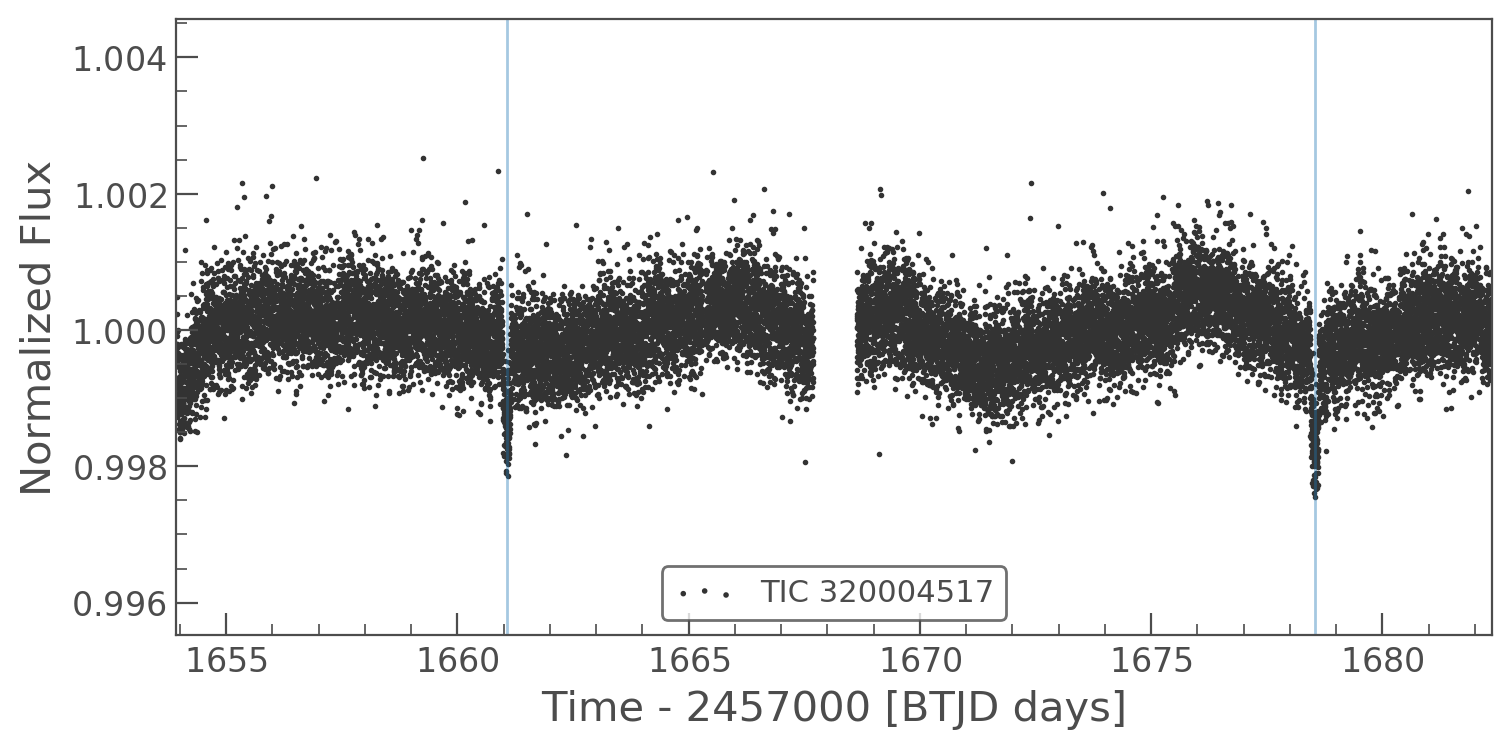

In [7]:
# Download the target pixel files
sr = lk.search_lightcurvefile('TIC {0}'.format(tic_id))
lc_collection = sr.download_all(quality_bitmask="hardest")
if lc_collection is None or not len(lc_collection):
    raise ValueError("we can't find any light curves")

# Extract the exposure time associated with the light curve
hdr = lc_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Loop over light curves and stitch
lc = lc_collection[0].PDCSAP_FLUX.remove_nans().normalize().remove_outliers()
for lc0 in lc_collection[1:]:
    lc = lc.append(lc0.PDCSAP_FLUX.remove_nans().normalize().remove_outliers())
    
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# This helper function shows the transit times
def indicate_transits(ax=None):
    if ax is None:
        ax = plt.gca()
    for i in range(len(periods)):
        mn = np.floor((x.min() - t0s[i]) / periods[i])
        mx = np.ceil((x.max() - t0s[i]) / periods[i])
        label = "planet {0}".format(letters[i])
        for ind in np.arange(mn, mx + 1):
            ax.axvline(t0s[i] + ind * periods[i], color="C{0}".format(i),
                       linewidth=1, alpha=0.4, label=label)
            label = None

# Plot the data
lc.scatter()
indicate_transits()
#plt.legend(fontsize=10)
plt.xlim(x.min(), x.max());

In [8]:
df = pd.read_csv("../../data/harps_rvs.csv")
for k in df.columns:
    new_k = k.strip("#").strip()
    if new_k != k:
        df[new_k] = df[k]
        del df[k]

In [9]:
BTJD_ref = 2457000
HARPS_upgrade = 2457218.5 # July 2015

# Remove one bisector outlier
df = df[df.bis < df.bis.max()]
        
df = df.sort_values("date")

x_rv = np.ascontiguousarray(df.bjd - BTJD_ref, dtype=np.float64)
HARPS_upgrade -= BTJD_ref
pug = np.ascontiguousarray(x_rv >= HARPS_upgrade, dtype=bool) # stands for post-upgrade, obviously
y_rv = np.ascontiguousarray(df.rv - df.rv.mean(), dtype=np.float64)
yerr_rv = np.ascontiguousarray(df.e_rv, dtype=np.float64)
bis_rv = np.ascontiguousarray((df.bis - df.bis.mean()) / df.bis.std(), dtype=np.float64)
fwhm_rv = np.ascontiguousarray((df.fwhm - df.fwhm.mean()) / df.fwhm.std(), dtype=np.float64)

In [10]:
y_rv_guess = np.copy(y_rv)
y_rv_guess[pug] -= 15.4

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv_guess, yerr_rv, t0s=t0s, m_star=mass_radius_mu[0])
msini = msini.to(u.M_earth)
print(msini)

[6.09623183] earthMass


In [11]:
t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None, bis=False, fwhm=False, rv_trend_order=1):
    if rv_trend_order < 1:
        assert False, "rv_trend_order must be >= 1"
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Stellar properties
        mr_star = pm.Bound(pm.MvNormal, lower=0)(
            "mr_star",
            mu=mass_radius_mu,
            chol=np.linalg.cholesky(mass_radius_cov),
            shape=2,
            testval=mass_radius_mu)
        m_star = pm.Deterministic("m_star", mr_star[0])
        r_star = pm.Deterministic("r_star", mr_star[1])
        
        mean_flux = pm.Normal("mean_flux", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")

        log_period = pm.Normal("log_period", mu=np.log(periods[0]), sd=10.0)
        period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Uniform("t0", lower=t0s[0]-1.0, upper=t0s[0]+1.0)
        
        log_ror = pm.Uniform("log_ror", lower=np.log(0.01), upper=np.log(0.1),
                             testval=0.5*np.log(1e-3*depths[0]))
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        b_hat = xo.distributions.UnitUniform("b_hat")
        b = pm.Deterministic("b", b_hat * (1 + ror))
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        
        log_m_pl = pm.Bound(pm.Normal, lower=0.0)(
            "log_m_pl", mu=np.log(msini.value[0]), sd=5)
        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        
        ecc = xo.distributions.eccentricity.kipping13("ecc", testval=np.zeros(n_pl)+0.01, shape=n_pl)
        #ecc = xo.distributions.UnitUniform("ecc", testval=np.zeros(n_pl)+0.01, shape=n_pl)
        omega = xo.distributions.Angle("omega")
        
        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)

        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
            
        # RV jitter & an RV trend
        logs_rv_pre = pm.Normal("logs_rv_pre", mu=np.log(np.median(yerr_rv[~pug])), sd=5)
        logs_rv_pug = pm.Normal("logs_rv_pug", mu=np.log(np.median(yerr_rv[pug])), sd=5)
        offset_pug = pm.Normal("offset_pug", mu=15.4, sd=0.4) # strong prior based on other solar twins
        trend = pm.Normal("trend", mu=0, sd=10.0**(1-np.arange(rv_trend_order))[::-1], shape=rv_trend_order)
        if bis:
            offset_pug_bis = pm.Normal("offset_pug_bis", mu=1., sd=5) # weak prior from eyeballing
            trend_bis = pm.Normal("trend_bis", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)
        if fwhm:
            offset_pug_fwhm = pm.Normal("offset_pug_fwhm", mu=1., sd=5) # weak prior from eyeballing
            trend_fwhm = pm.Normal("trend_fwhm", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)
            
        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega,
            m_planet=m_pl, 
            m_planet_units=msini.unit)
        
        # Save some helpful things for later
        semimajor = orbit.a
        pm.Deterministic('a', semimajor)

        # Compute the model light curve using starry
        model.light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) + mean_flux

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        model.gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()))
        pm.Potential("transit_obs", model.gp.log_likelihood(y[mask] - model.light_curve))
        model.gp_pred = model.gp.predict()

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)
        
        # Define the background RV model
        A = np.vander(x_rv, rv_trend_order)
        bkg_terms = pug*offset_pug + tt.dot(A, trend)
        bkg_noactivity = pm.Deterministic("bkg_noactivity", bkg_terms)
        if bis:
            A_bis = np.vander(bis_rv, 2)
            bkg_terms += tt.dot(A_bis, trend_bis) + pug*offset_pug_bis*trend_bis[0]
        if fwhm:
            A_fwhm = np.vander(fwhm_rv, 2)
            bkg_terms += tt.dot(A_fwhm, trend_fwhm) + pug*offset_pug_fwhm*trend_fwhm[0]            
        bkg = pm.Deterministic("bkg", bkg_terms)


        # The likelihood for the RVs
        if n_pl > 1:
            rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        else:
            rv_model = pm.Deterministic("rv_model", vrad + bkg)        
        err_pre = tt.sqrt(yerr_rv[~pug]**2 + tt.exp(2*logs_rv_pre))
        err_pug = tt.sqrt(yerr_rv[pug]**2 + tt.exp(2*logs_rv_pug))
        pm.Normal("obs_pre", mu=rv_model[~pug], sd=err_pre, observed=y_rv[~pug])
        pm.Normal("obs_post", mu=rv_model[pug], sd=err_pug, observed=y_rv[pug])
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        pug_pred = t_rv >= HARPS_upgrade
        A_pred = np.vander(t_rv, rv_trend_order)        
        bkg_pred = pm.Deterministic("bkg_pred", pug_pred*offset_pug + tt.dot(A_pred, trend))
        if n_pl > 1:
            pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)
        else:
            pm.Deterministic("rv_model_pred", vrad_pred + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logs_rv_pre, logs_rv_pug, trend, offset_pug])
        if bis:
            map_soln = xo.optimize(start=map_soln, vars=[trend_bis, offset_pug_bis])
        if fwhm:
            map_soln = xo.optimize(start=map_soln, vars=[trend_fwhm, offset_pug_fwhm])
        map_soln = xo.optimize(start=map_soln, vars=[log_ror, b_hat])
        map_soln = xo.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = xo.optimize(start=map_soln, vars=[log_m_pl])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

### 1-planet fit:

In [12]:
model, map_soln = build_model(fwhm=False, rv_trend_order=3)

optimizing logp for variables: [logs2]
9it [00:01,  8.38it/s, logp=-1.257588e+04]
message: Optimization terminated successfully.
logp: -13259.984782775615 -> -12575.878280260044
optimizing logp for variables: [offset_pug, trend, logs_rv_pug, logs_rv_pre]
53it [00:00, 86.34it/s, logp=-1.105619e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: -12575.878280260044 -> -11056.19351613284
optimizing logp for variables: [b_hat, log_ror]
10it [00:00, 21.35it/s, logp=-1.102679e+04]
message: Optimization terminated successfully.
logp: -11056.193516132837 -> -11026.79260999812
optimizing logp for variables: [t0, log_period]
135it [00:01, 132.44it/s, logp=-1.102653e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -11026.79260999812 -> -11026.532010948362
optimizing logp for variables: [log_m_pl]
11it [00:00, 22.44it/s, logp=-1.102444e+04] 
message: Optimization terminated successfully.
logp: -11026.532010948362 -> -11024.44018583542

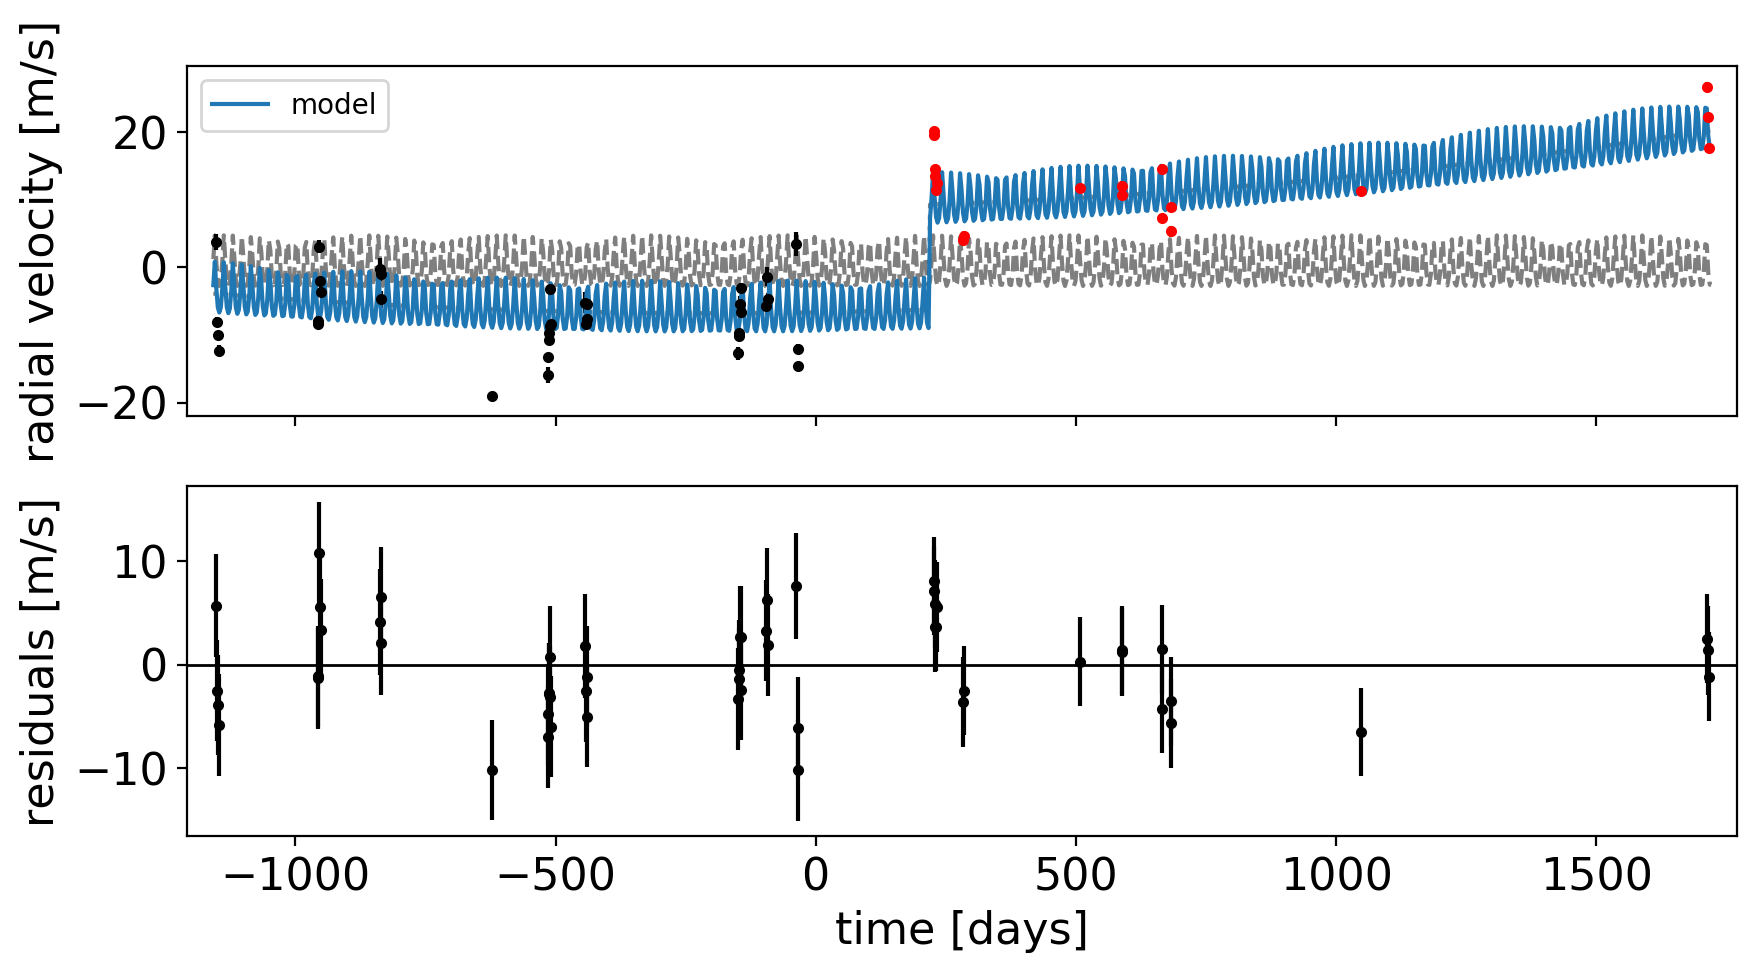

In [13]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

    ax = axes[0]
    ax.errorbar(x_rv[~pug], y_rv[~pug], yerr=yerr_rv[~pug], fmt=".k")
    ax.errorbar(x_rv[pug], y_rv[pug], yerr=yerr_rv[pug], fmt=".r")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")

    ax = axes[1]
    err_pre = np.sqrt(yerr_rv[~pug]**2+np.exp(2*soln["logs_rv_pre"]))
    err_pug = np.sqrt(yerr_rv[pug]**2+np.exp(2*soln["logs_rv_pug"]))
    ax.errorbar(x_rv[~pug], y_rv[~pug] - soln["rv_model"][~pug], yerr=err_pre, fmt=".k")
    ax.errorbar(x_rv[pug], y_rv[pug] - soln["rv_model"][pug], yerr=err_pug, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min() - 50, t_rv.max() + 50)
    ax.set_xlabel("time [days]")

plot_rv_curve(map_soln)

/Users/mbedell/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


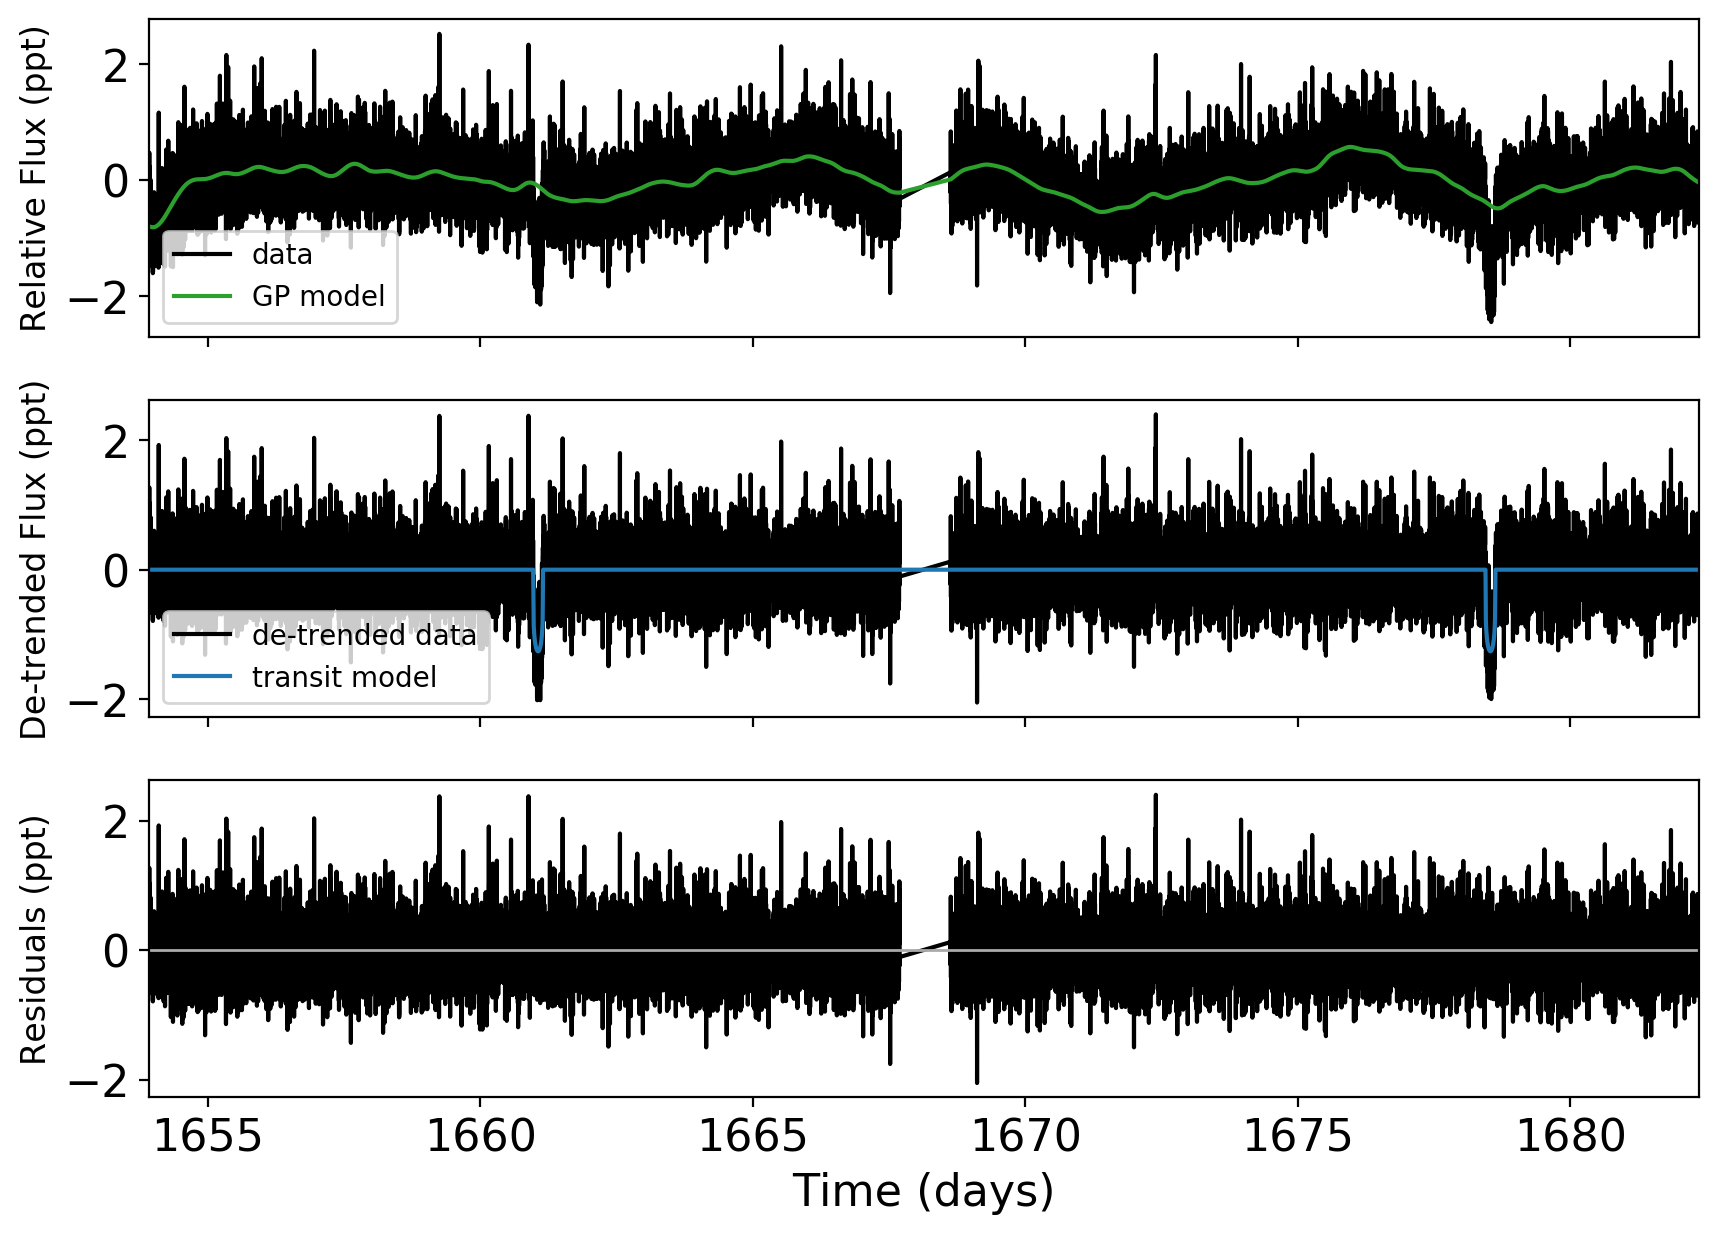

In [14]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
    
    with model:
        gp_mod, lc_mod = xo.eval_in_model([
            model.gp_pred + model.mean_flux, model.light_curve - model.mean_flux], soln)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    ax.plot(x[mask], gp_mod, color="C2", label="GP model")
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("Relative Flux (ppt)", fontsize=12)

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    ax.plot(x[mask], lc_mod, label="transit model")
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("De-trended Flux (ppt)", fontsize=12)

    ax = axes[2]
    mod = gp_mod + lc_mod
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("Residuals (ppt)", fontsize=12)
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("Time (days)")

    return fig

fig = plot_light_curve(model, map_soln)
fig.show();

peak at 1.0383 +/- 0.0002 days with log(power) = 2.46
peak at 119.9255 +/- 1.8793 days with log(power) = 2.40
peak at 98.9630 +/- 2.2466 days with log(power) = 2.33
peak at 1.0101 +/- 0.0002 days with log(power) = 2.32
peak at 1.0257 +/- 0.0002 days with log(power) = 2.30


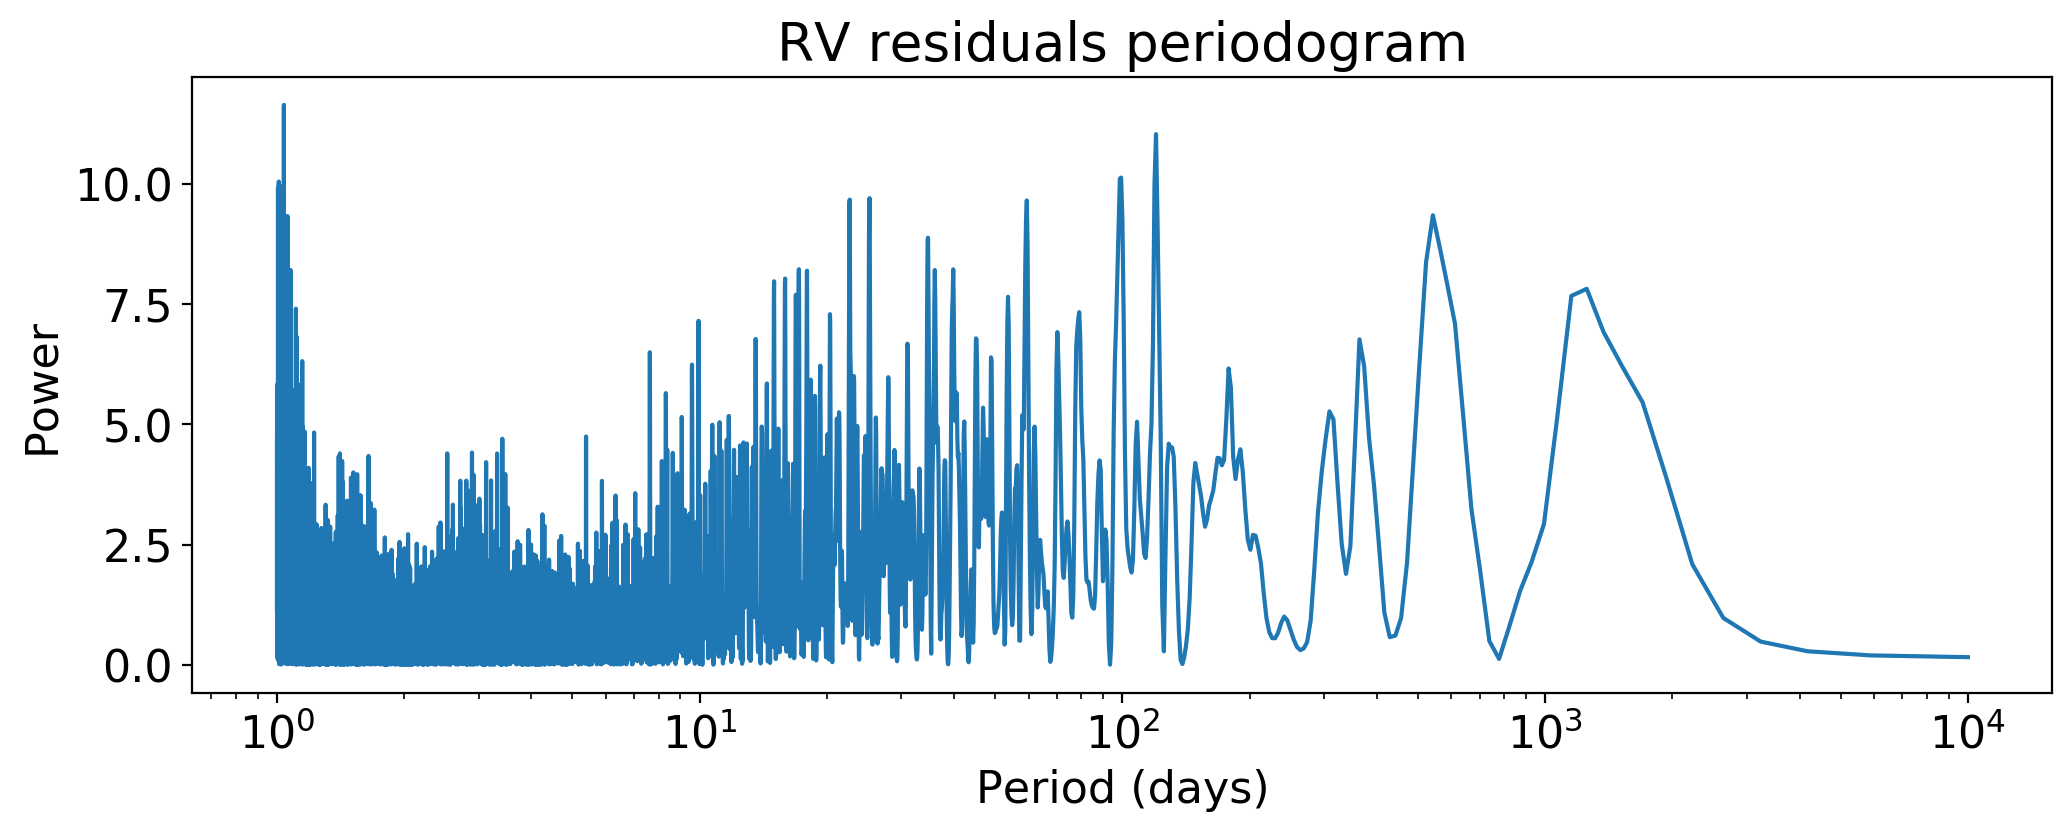

In [15]:
pg = xo.lomb_scargle_estimator(x_rv, y_rv - map_soln["rv_model"], yerr=yerr_rv, 
                               min_period=1, max_period=1e4, max_peaks=5)

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./pg['periodogram'][0], pg['periodogram'][1])
ax.set_xscale('log')
ax.set_title('RV residuals periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
for p in pg['peaks']:
    print('peak at {0:.4f} +/- {1:.4f} days with log(power) = {2:.2f}'.format(p['period'], 
                                                                              p['period_uncert'], p['log_power']))

In [16]:
if run_trace:
    with model:
        trace = pm.sample(tune=1000, draws=1000, start=map_soln, chains=2,
                      step=xo.get_dense_nuts_step(target_accept=0.9))
    pm.save_trace(trace,directory='pymc_1pl', overwrite=True)   
else:
    with model:
        trace = pm.load_trace('pymc_1pl')

In [17]:
def percentiles(x):
    # this fails for unknown indexing-related reasons
    return pd.DataFrame(np.percentile(x, [0.15, 16, 50, 84, 99.85]), 
                        columns=['3sigma_lower', '1sigma_lower', 'median', '1sigma_upper', '3sigma_upper'],
                        dtype=np.float64)

def median(x):
    return pd.Series(np.percentile(x, [50]), name='median')

def onesigma_upper(x):
    return pd.Series(np.percentile(x, [84]), name='1sigma_upper')

def onesigma_lower(x):
    return pd.Series(np.percentile(x, [16]), name='1sigma_lower')

def threesigma_upper(x):
    return pd.Series(np.percentile(x, [99.85]), name='3sigma_upper')

def threesigma_lower(x):
    return pd.Series(np.percentile(x, [0.15]), name='3sigma_lower')
    
    
if run_trace:
    s = pm.summary(trace, varnames=[k for k in trace.varnames 
                                if not k.endswith("__") 
                                and not k in ("vrad", "vrad_pred", "bkg", "bkg_noactivity", 
                                              "rv_model", "rv_model_pred", "bkg_pred")],
                  extend = True, stat_funcs=[median, onesigma_lower, onesigma_upper,
                                            threesigma_lower, threesigma_upper])

    s.to_pickle('summary_1pl.p')
else:
    s = pd.read_pickle('summary_1pl.p')
    
s

mean        sd      mc_error      hpd_2.5     hpd_97.5  \
mean_flux      -0.016829  0.061608  1.363623e-03    -0.138196     0.103670   
log_period      2.860561  0.000087  2.028593e-06     2.860381     2.860730   
logs2          -1.751233  0.010832  3.541469e-04    -1.770867    -1.729852   
logw0           0.740647  0.151553  3.631122e-03     0.437528     1.025772   
logpower        0.033316  0.309095  6.912117e-03    -0.571683     0.643103   
logs_rv_pre     1.607029  0.135468  3.757700e-03     1.367799     1.893186   
logs_rv_pug     1.590120  0.191997  6.426229e-03     1.267553     1.994263   
offset_pug     15.523557  0.398781  9.462372e-03    14.729609    16.301711   
trend__0        0.000003  0.000001  2.793725e-08     0.000002     0.000006   
trend__1        0.001600  0.001098  3.174200e-05    -0.000418     0.003752   
trend__2       -6.917737  0.958871  2.188620e-02    -8.767963    -5.040226   
mr_star__0      0.982333  0.001611  4.590208e-05     0.979302     0.985451   
mr_star__1      0.957578  0.006485  1.428339e-04     0.945353     0.969895   
m_star          0.982333  0.001611  4.590208e-05     0.979302     0.985451   
r_star          0.957578  0.006485  1.428339e-04     0.945353     0.969895   
u_star__0       0.400348  0.219879  5.822698e-03     0.000191     0.784469   
u_star__1       0.207466  0.323566  1.011337e-02    -0.367513     0.763021   
period         17.471330  0.001520  3.544221e-05    17.468175    17.474277   
t0           1661.062820  0.001014  2.963110e-05  1661.060995  1661.064913   
log_ror        -3.421357  0.023810  7.292744e-04    -3.470835    -3.378283   
ror             0.032677  0.000778  2.396769e-05     0.031091     0.034106   
b_hat           0.275293  0.153193  6.064171e-03     0.001152     0.531560   
b               0.284347  0.158338  6.268723e-03     0.002037     0.549888   
r_pl            0.031291  0.000778  2.459538e-05     0.029734     0.032785   
log_m_pl        2.073786  0.661720  3.082415e-02     0.557084     3.048574   
m_pl            9.487572  4.848872  2.052012e-01     1.095907    17.823778   
ecc_alpha       1.118777  0.104779  3.667924e-03     0.929991     1.320917   
ecc_beta        3.088202  0.305295  1.129273e-02     2.468784     3.628275   
ecc__0          0.152062  0.125116  7.273122e-03     0.000281     0.431311   
omega           0.217049  1.309494  5.362721e-02    -2.443739     3.140979   
logS0          -2.929271  0.414637  1.007199e-02    -3.666024    -2.095610   

                  median  1sigma_lower  1sigma_upper  3sigma_lower  \
mean_flux      -0.016257     -0.077553      0.042570     -0.213221   
log_period      2.860565      2.860478      2.860642      2.860276   
logs2          -1.751448     -1.762162     -1.740309     -1.780487   
logw0           0.744408      0.594415      0.892854      0.247334   
logpower        0.031261     -0.257952      0.335922     -0.902638   
logs_rv_pre     1.604672      1.478089      1.740370      1.267980   
logs_rv_pug     1.586416      1.393966      1.780554      1.111672   
offset_pug     15.535436     15.133685     15.908075     14.325613   
trend__0        0.000003     -6.956798      0.001681     -9.715232   
trend__1             NaN           NaN           NaN           NaN   
trend__2             NaN           NaN           NaN           NaN   
mr_star__0      0.977615      0.954357      0.983093      0.940489   
mr_star__1           NaN           NaN           NaN           NaN   
m_star          0.982324      0.980714      0.983959      0.977904   
r_star          0.957792      0.951011      0.964048      0.940012   
u_star__0       0.318149      0.003752      0.605709     -0.434102   
u_star__1            NaN           NaN           NaN           NaN   
period         17.471398     17.469879     17.472742     17.466342   
t0           1661.062776   1661.061782   1661.063814   1661.060383   
log_ror        -3.421261     -3.445623     -3.398106     -3.486625   
ror             0.032671      0.031885      0.033437 

In [18]:
keep = np.percentile(trace['mr_star'], [0.15, 16, 50, 84, 99.85], axis=0)
print(keep)
#pd.DataFrame.from_dict(keep, orient = 'index')
#pd.DataFrame(list(keep.values()), columns=['3sigma_lower', '1sigma_lower', 'median', '1sigma_upper', '3sigma_upper'])

[[0.97790359 0.94001227]
 [0.9807144  0.95101141]
 [0.98232403 0.9577918 ]
 [0.9839591  0.96404832]
 [0.98674087 0.97437223]]


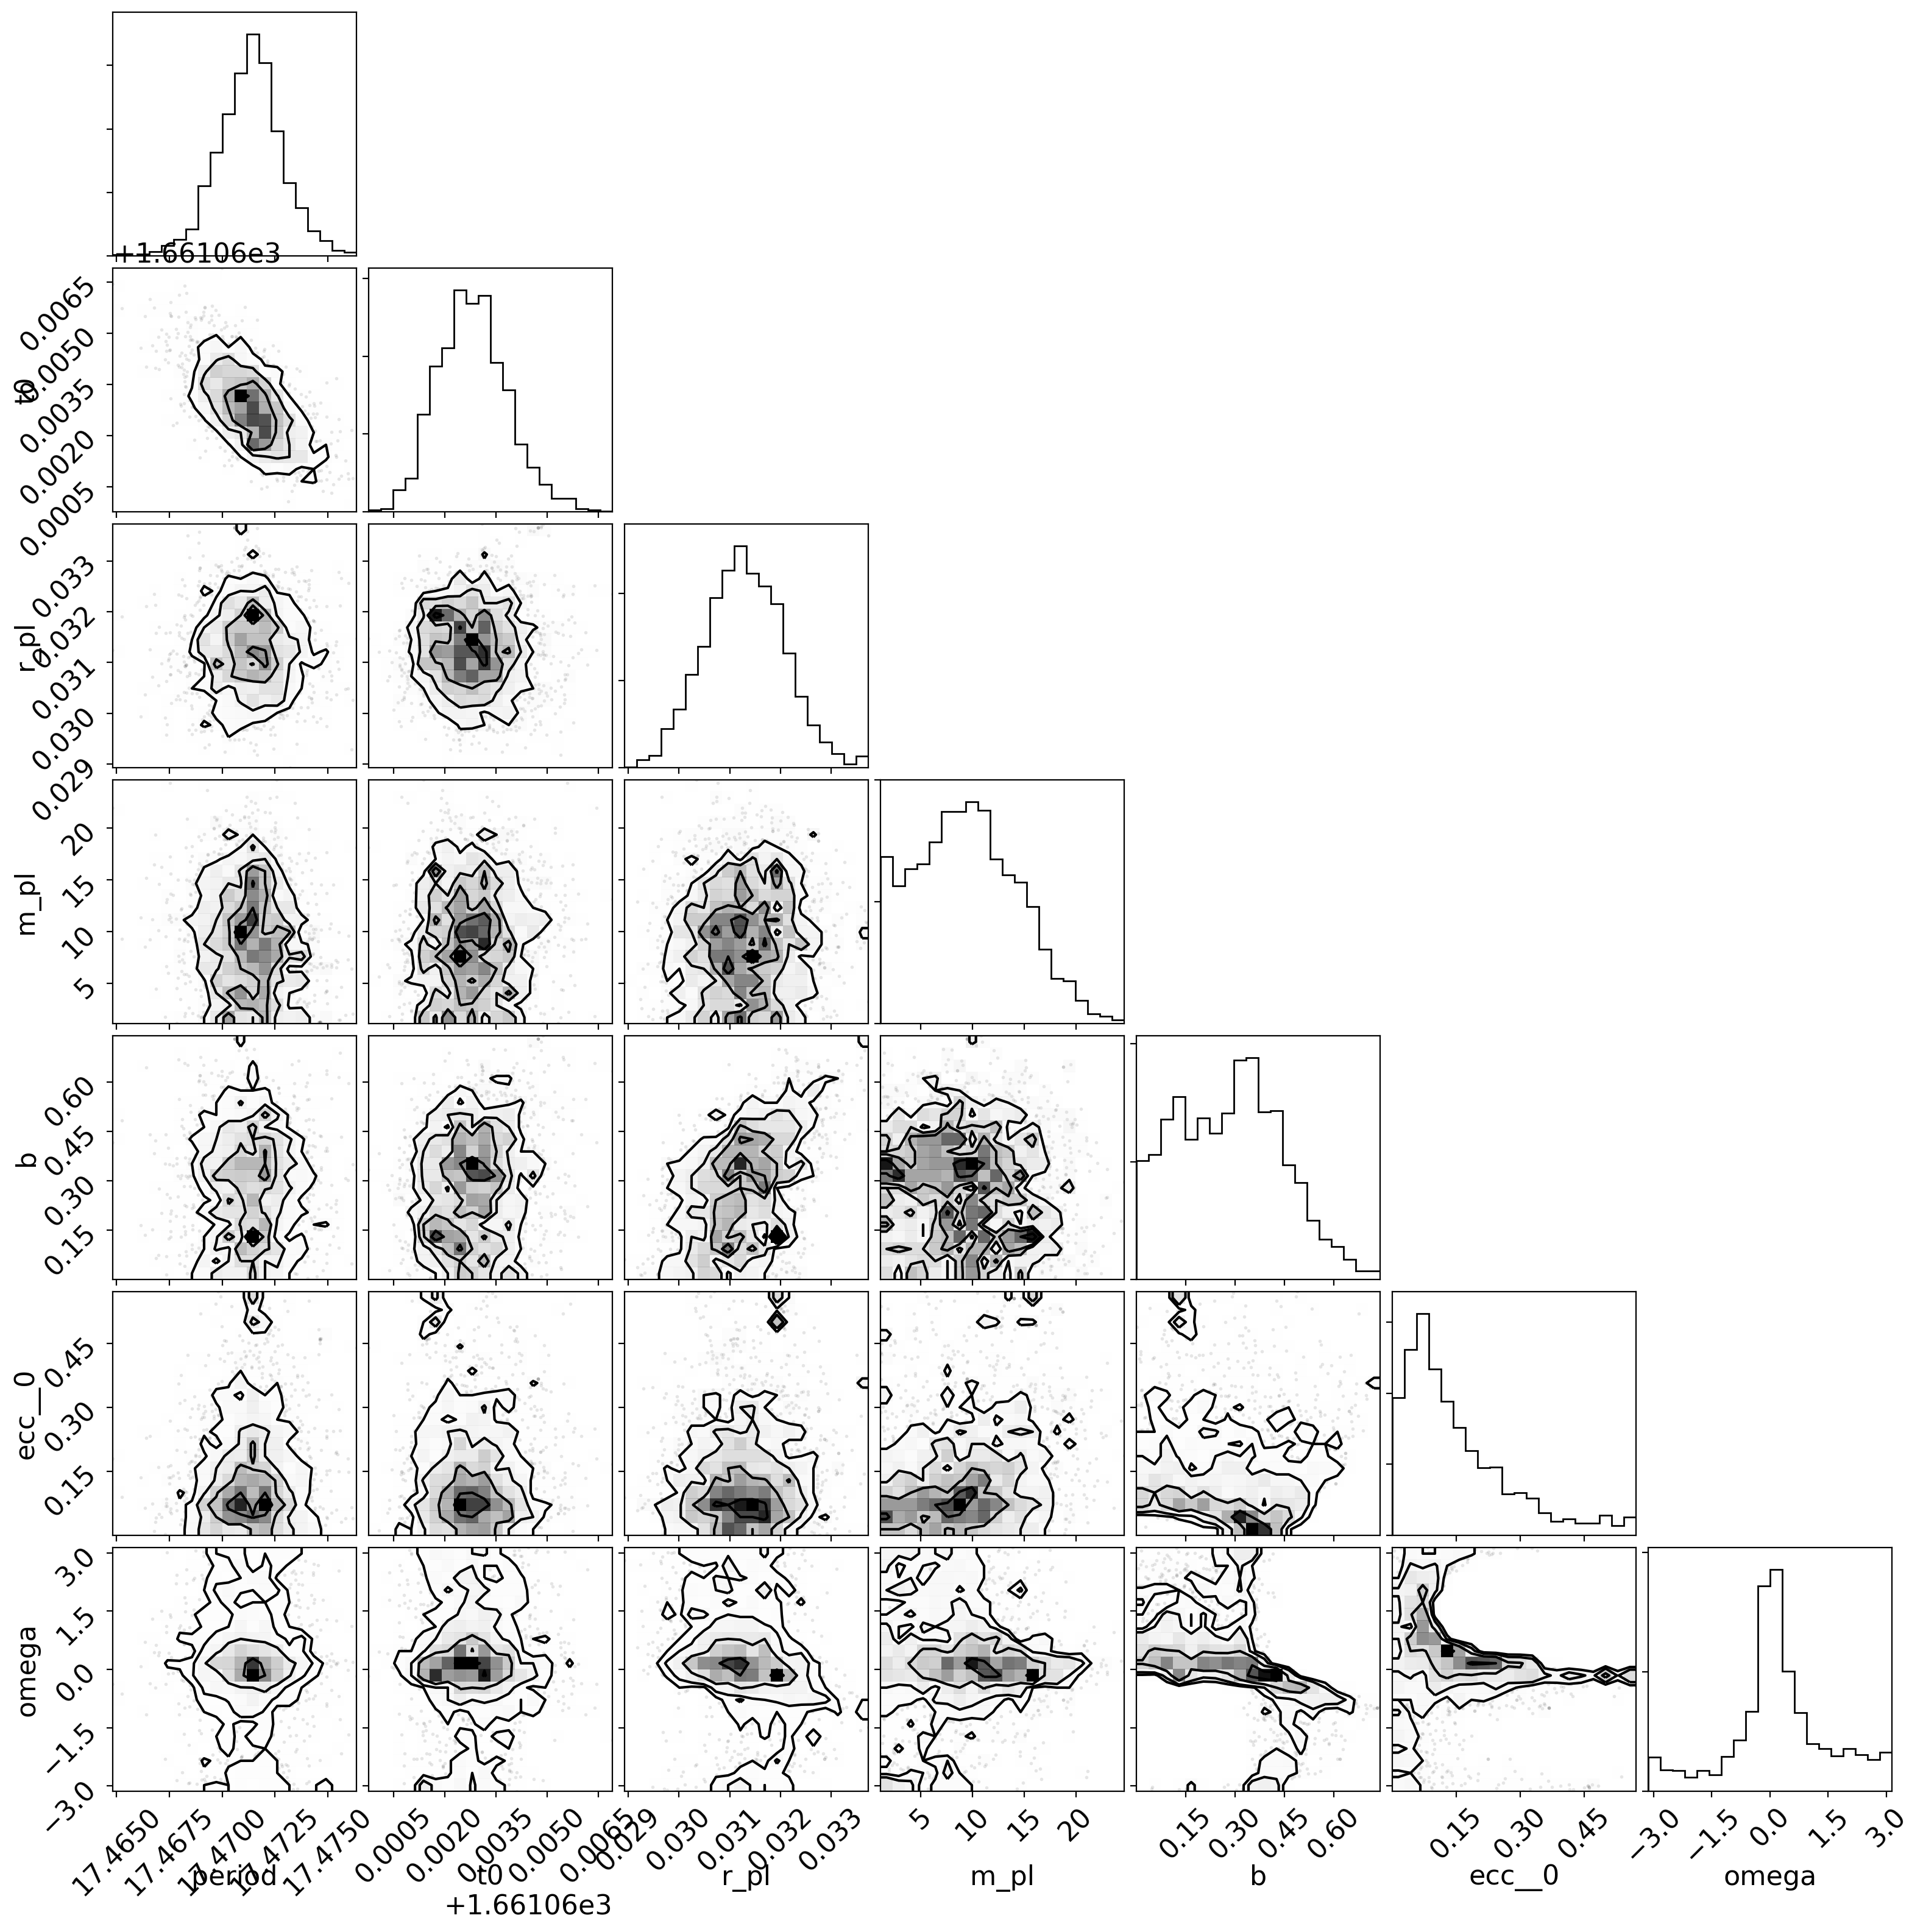

In [19]:
varnames = ["period", "t0", "r_pl", "m_pl", "b", "ecc", "omega"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

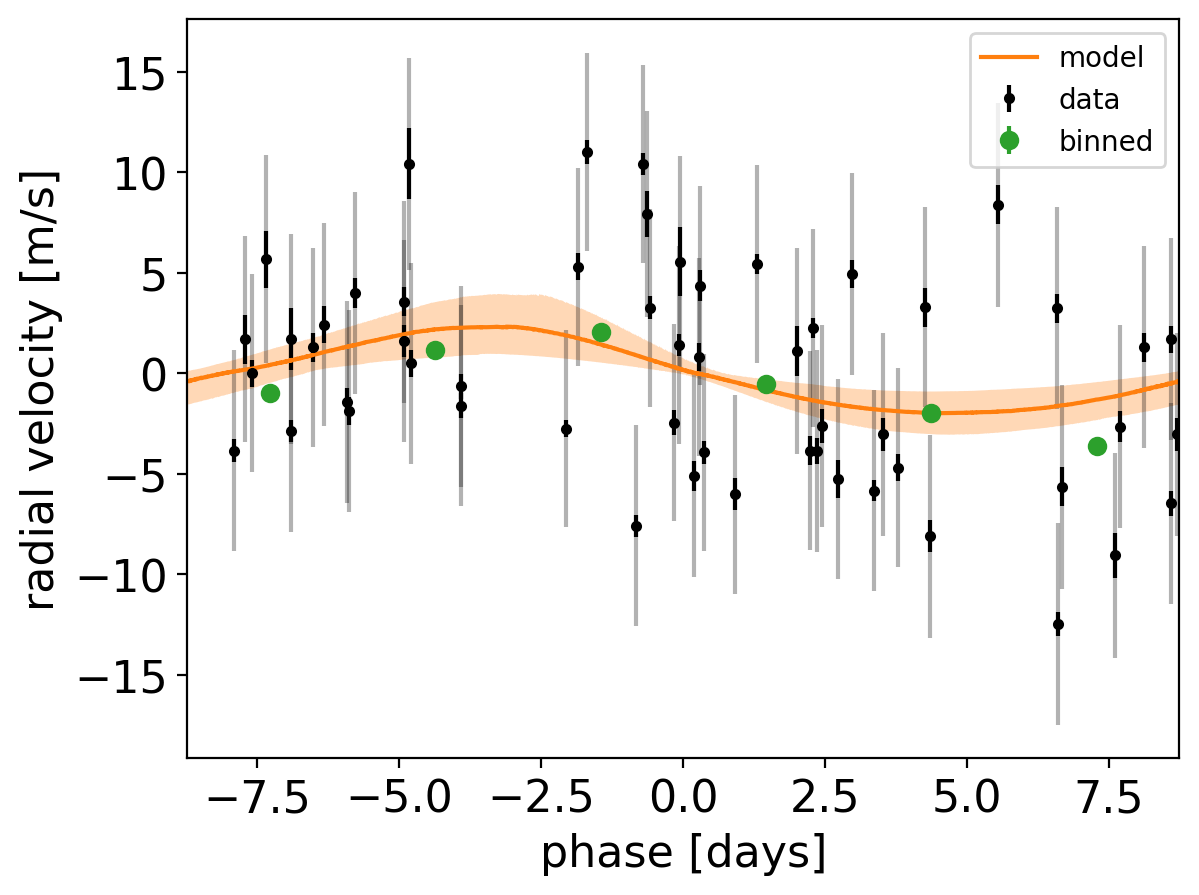

In [20]:
# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])
jit2_pre = np.exp(2*np.median(trace["logs_rv_pre"]))
jit2_pug = np.exp(2*np.median(trace["logs_rv_pug"]))


bkg = np.median(trace["bkg"], axis=0)

# Plot the folded data
x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold[~pug], y_rv[~pug] - bkg[~pug], yerr=np.sqrt(yerr_rv[~pug]**2 + jit2_pre), fmt=",k", alpha=0.3)
plt.errorbar(x_fold[pug], y_rv[pug] - bkg[pug], yerr=np.sqrt(yerr_rv[pug]**2 + jit2_pug), fmt=",k", alpha=0.3)
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_rv, fmt=".k", label="data")

bins = np.linspace(-0.5 * p, 0.5*p, 7)
num, _ = np.histogram(x_fold, bins, weights=(y_rv - bkg) / yerr_rv**2)
denom, _ = np.histogram(x_fold, bins, weights=1 / yerr_rv**2)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Compute the posterior prediction for the folded RV model for this
# planet
t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
pred = np.percentile(trace["vrad_pred"][:, inds], [16, 50, 84], axis=0)
plt.plot(t_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("phase [days]")
plt.ylabel("radial velocity [m/s]");
#plt.savefig(plot_dir+'rvphased_1pl.pdf');

### 1-planet fit with FWHM correlation:

**This is the model currently used in the paper draft**

In [21]:
model, map_soln = build_model(fwhm=True, rv_trend_order=3)

optimizing logp for variables: [logs2]
9it [00:00, 17.67it/s, logp=-1.258255e+04] 
message: Optimization terminated successfully.
logp: -13266.653621380658 -> -12582.547118865086
optimizing logp for variables: [offset_pug, trend, logs_rv_pug, logs_rv_pre]
53it [00:00, 81.57it/s, logp=-1.106286e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: -12582.547118865086 -> -11062.862354737883
optimizing logp for variables: [offset_pug_fwhm, trend_fwhm]
14it [00:00, 17.05it/s, logp=-1.106069e+04] 
message: Optimization terminated successfully.
logp: -11062.862354737883 -> -11060.69234432154
optimizing logp for variables: [b_hat, log_ror]
10it [00:00, 20.41it/s, logp=-1.103129e+04]
message: Optimization terminated successfully.
logp: -11060.692344321536 -> -11031.291448928596
optimizing logp for variables: [t0, log_period]
89it [00:00, 107.70it/s, logp=-1.103102e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -11031.291448928592 

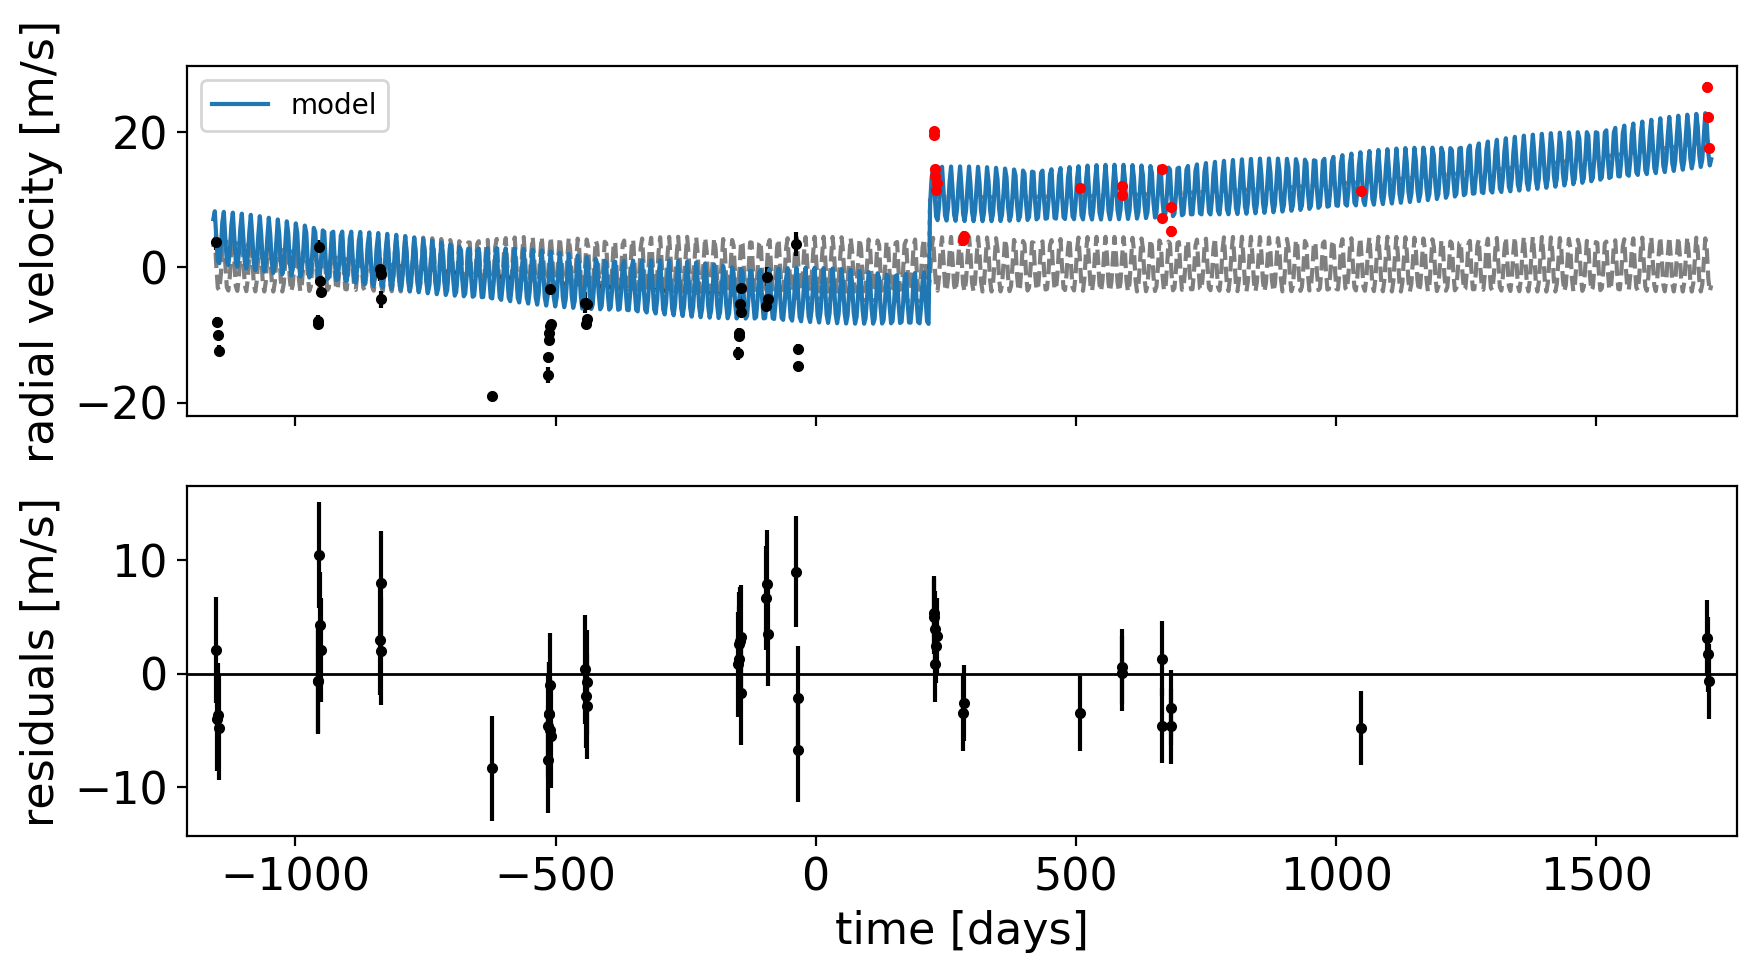

In [22]:
plot_rv_curve(map_soln);

/Users/mbedell/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


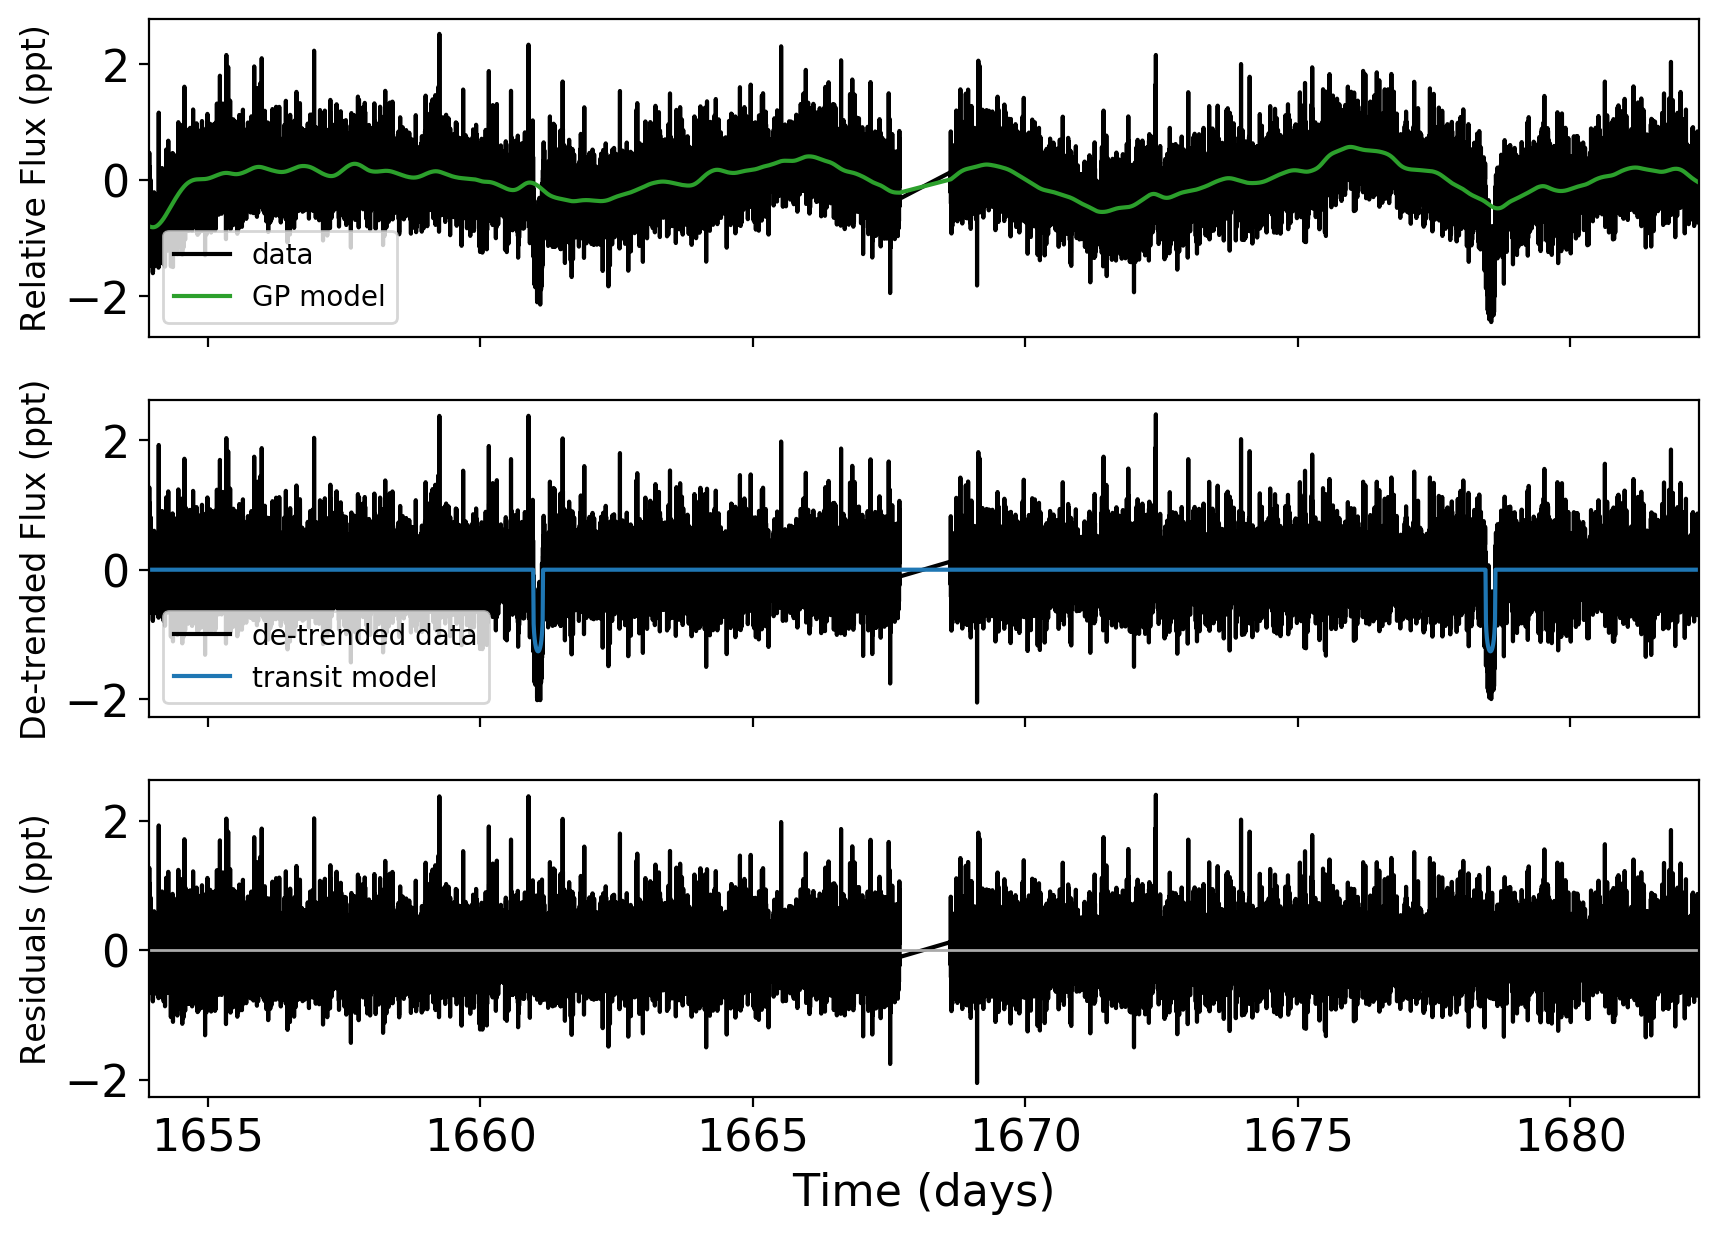

In [23]:
fig = plot_light_curve(model, map_soln)
fig.savefig(plot_dir+'lightcurve.pdf')
fig.show();

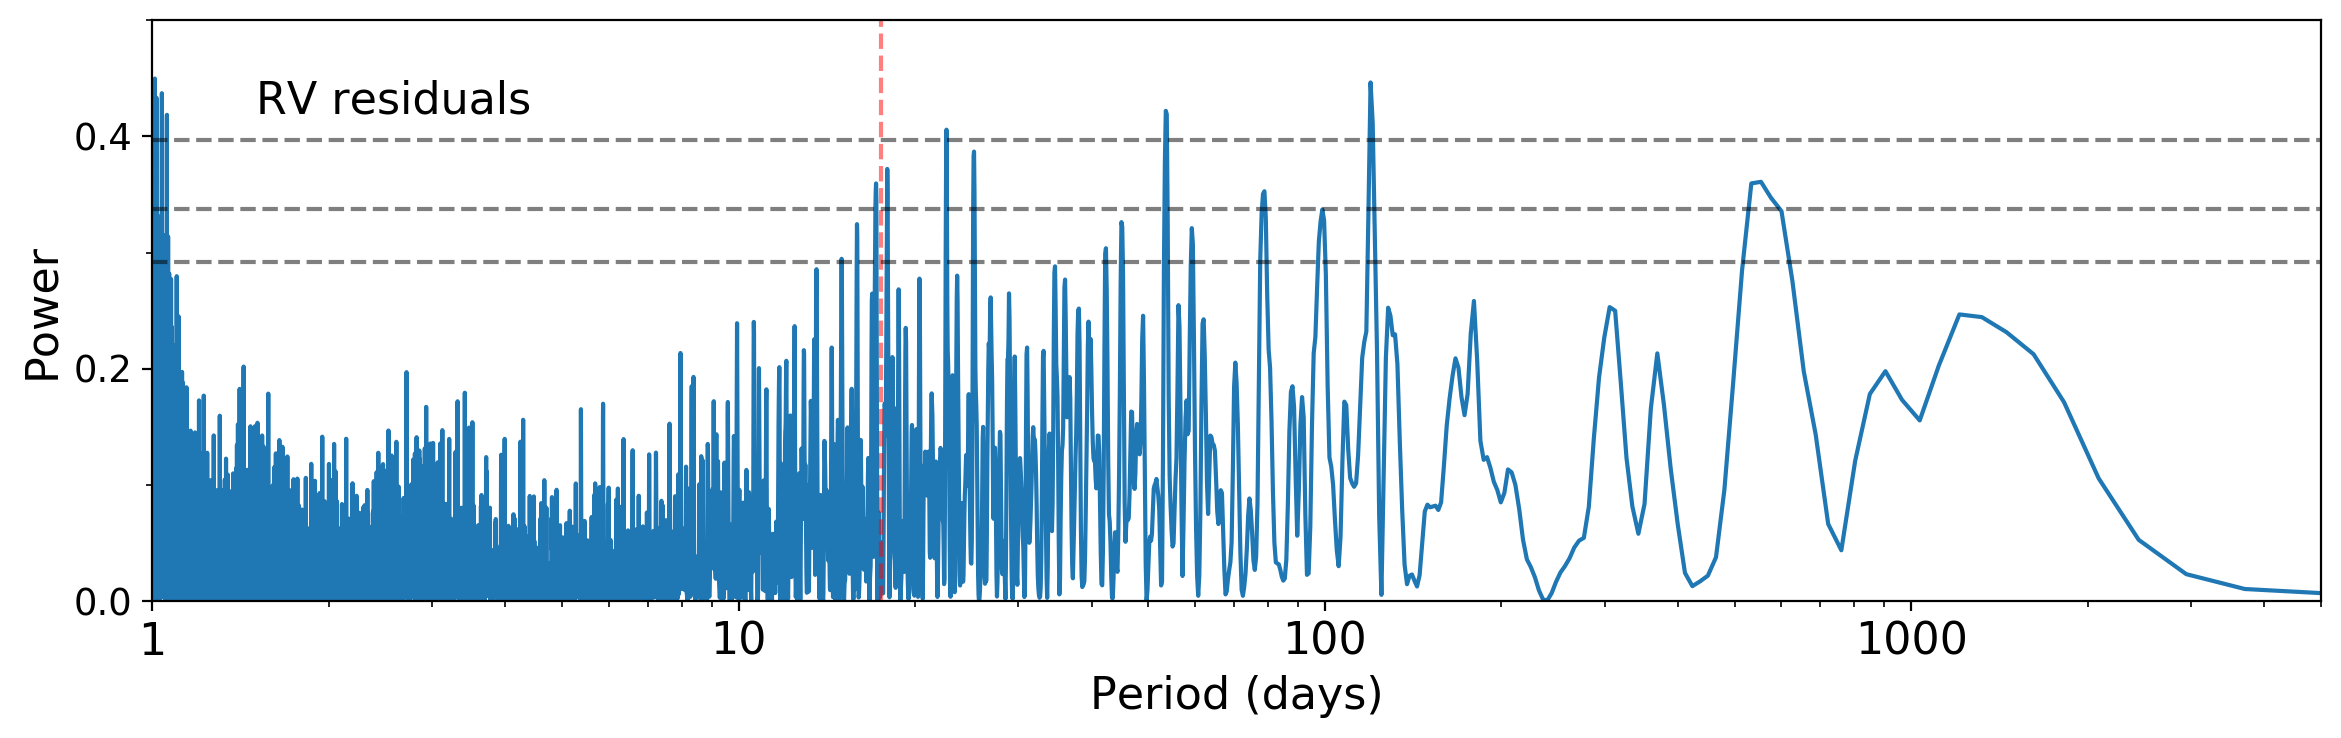

In [24]:
pg = xo.lomb_scargle_estimator(x_rv, y_rv - map_soln["rv_model"], yerr=yerr_rv, 
                               min_period=1, max_period=1e4, max_peaks=5)
    
from astropy.timeseries import LombScargle
ls = LombScargle(x_rv, y_rv - map_soln["rv_model"], yerr_rv)
freq, power = ls.autopower(minimum_frequency=2.e-4, maximum_frequency=1.)

probabilities = [0.05, 0.01, 0.001]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
ax.axvline(17.47114, c='r', alpha=0.5, ls='--')
for f in fal:
    ax.axhline(f, c='k', alpha=0.5, ls='--')
ax.text(1.5, 0.42, 'RV residuals')
ax.set_xscale('log')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
ax.set_xlim([1.,5.e3])
ax.set_ylim([0.,0.5])
ax.set_yticks([0.,0.2,0.4], minor=False)
ax.set_yticks([0.1,0.3,0.5], minor=True)
ax.tick_params(labelsize='small', axis='y')
ax.set_xticklabels(['0.1','1', '10', '100', '1000'])
fig.tight_layout()
plt.savefig(plot_dir+'periodogram_resids2.pdf');

In [25]:
if run_trace:
    with model:
        trace = pm.sample(tune=1000, draws=1000, start=map_soln, chains=2,
                      step=xo.get_dense_nuts_step(target_accept=0.9))
    pm.save_trace(trace,directory='pymc_1pl_wfwhm', overwrite=True)   
else:
    with model:
        trace = pm.load_trace('pymc_1pl_wfwhm')

In [26]:
if run_trace:
    s = pm.summary(trace, varnames=[k for k in trace.varnames 
                                if not k.endswith("__") 
                                and not k in ("vrad", "vrad_pred", "bkg", "bkg_noactivity", 
                                              "rv_model", "rv_model_pred", "bkg_pred")],
                  extend = True, stat_funcs=[median, onesigma_lower, onesigma_upper,
                                            threesigma_lower, threesigma_upper])
    s.to_pickle('summary_1pl_wfwhm.p')
else:
    s = pd.read_pickle('summary_1pl_wfwhm.p')
    
s

mean        sd      mc_error      hpd_2.5  \
mean_flux          -0.019833  0.062510  1.382631e-03    -0.138581   
log_period          2.860565  0.000085  1.779919e-06     2.860387   
logs2              -1.751788  0.009955  2.274476e-04    -1.769933   
logw0               0.746154  0.154587  3.610896e-03     0.451233   
logpower            0.047983  0.319764  6.582418e-03    -0.555543   
logs_rv_pre         1.561625  0.129155  2.845368e-03     1.317349   
logs_rv_pug         1.324236  0.201611  5.429052e-03     0.893629   
offset_pug         15.409673  0.397728  7.790572e-03    14.578627   
trend__0            0.000004  0.000001  2.900798e-08     0.000002   
trend__1           -0.002204  0.001910  5.830967e-05    -0.006086   
trend__2           -4.272764  6.889502  1.394864e-01   -17.721290   
offset_pug_fwhm     3.146138  2.382958  8.536551e-02    -1.162146   
trend_fwhm__0       1.509233  0.569979  1.785207e-02     0.451729   
trend_fwhm__1      -4.811931  6.913976  1.459795e-01   -17.686792   
mr_star__0          0.982364  0.001524  3.631230e-05     0.979469   
mr_star__1          0.957481  0.006323  1.439009e-04     0.946070   
m_star              0.982364  0.001524  3.631230e-05     0.979469   
r_star              0.957481  0.006323  1.439009e-04     0.946070   
u_star__0           0.397213  0.214773  5.578961e-03     0.009623   
u_star__1           0.220675  0.328568  9.341272e-03    -0.344419   
period             17.471401  0.001493  3.109729e-05    17.468286   
t0               1661.062783  0.000996  2.166662e-05  1661.060940   
log_ror            -3.424891  0.021600  5.290282e-04    -3.467302   
ror                 0.032560  0.000702  1.718818e-05     0.031201   
b_hat               0.267808  0.133169  4.889795e-03     0.003432   
b                   0.276563  0.137583  5.051945e-03     0.005846   
r_pl                0.031176  0.000702  1.658785e-05     0.029793   
log_m_pl            2.492509  0.461764  2.387121e-02     1.484582   
m_pl               13.186250  4.747814  1.966790e-01     3.308791   
ecc_alpha           1.108739  0.098533  2.245265e-03     0.930621   
ecc_beta            3.110961  0.298515  6.360748e-03     2.529181   
ecc__0              0.088873  0.063412  2.125807e-03     0.000202   
omega               0.508197  1.586923  5.044488e-02    -2.870578   
logS0              -2.936634  0.418283  9.825331e-03    -3.675142   
a                  28.167790  0.014662  3.455152e-04    28.139162   

                    hpd_97.5       median  1sigma_lower  1sigma_upper  \
mean_flux           0.103059    -0.018711     -0.079221      0.039908   
log_period          2.860725     2.860566      2.860485      2.860648   
logs2              -1.731195    -1.751865     -1.761666     -1.741694   
logw0               1.044153     0.750091      0.589281      0.899777   
logpower            0.690792     0.042938     -0.265398      0.370190   
logs_rv_pre         1.805406     1.559673      1.431832      1.692499   
logs_rv_pug         1.696173     1.318241      1.130712      1.528062   
offset_pug         16.123737    15.421255     15.009421     15.823075   
trend__0            0.000006    -0.000728     -4.504621      0.000006   
trend__1            0.001377          NaN           NaN           NaN   
trend__2            9.259667          NaN           NaN           NaN   
offset_pug_fwhm     7.827416     2.834139      0.961071      5.288035   
trend_fwhm__0       2.641163     1.027005     -8.072621      2.103449   
trend_fwhm__1       8.929291          NaN           NaN           NaN   
mr_star__0          0.985549     0.976969      0.954619      0.983060   
mr_star__1          0.971025          NaN           NaN           NaN   
m_star              0.985549     0.982395      0.980888      0.983829   
r_star              0.971025     0.957570      0.951128      0.963841   
u_star__0           0.768874     0.323567      0.020093      0.606644   
u_star__1           0.820004          NaN           NaN           NaN   
period

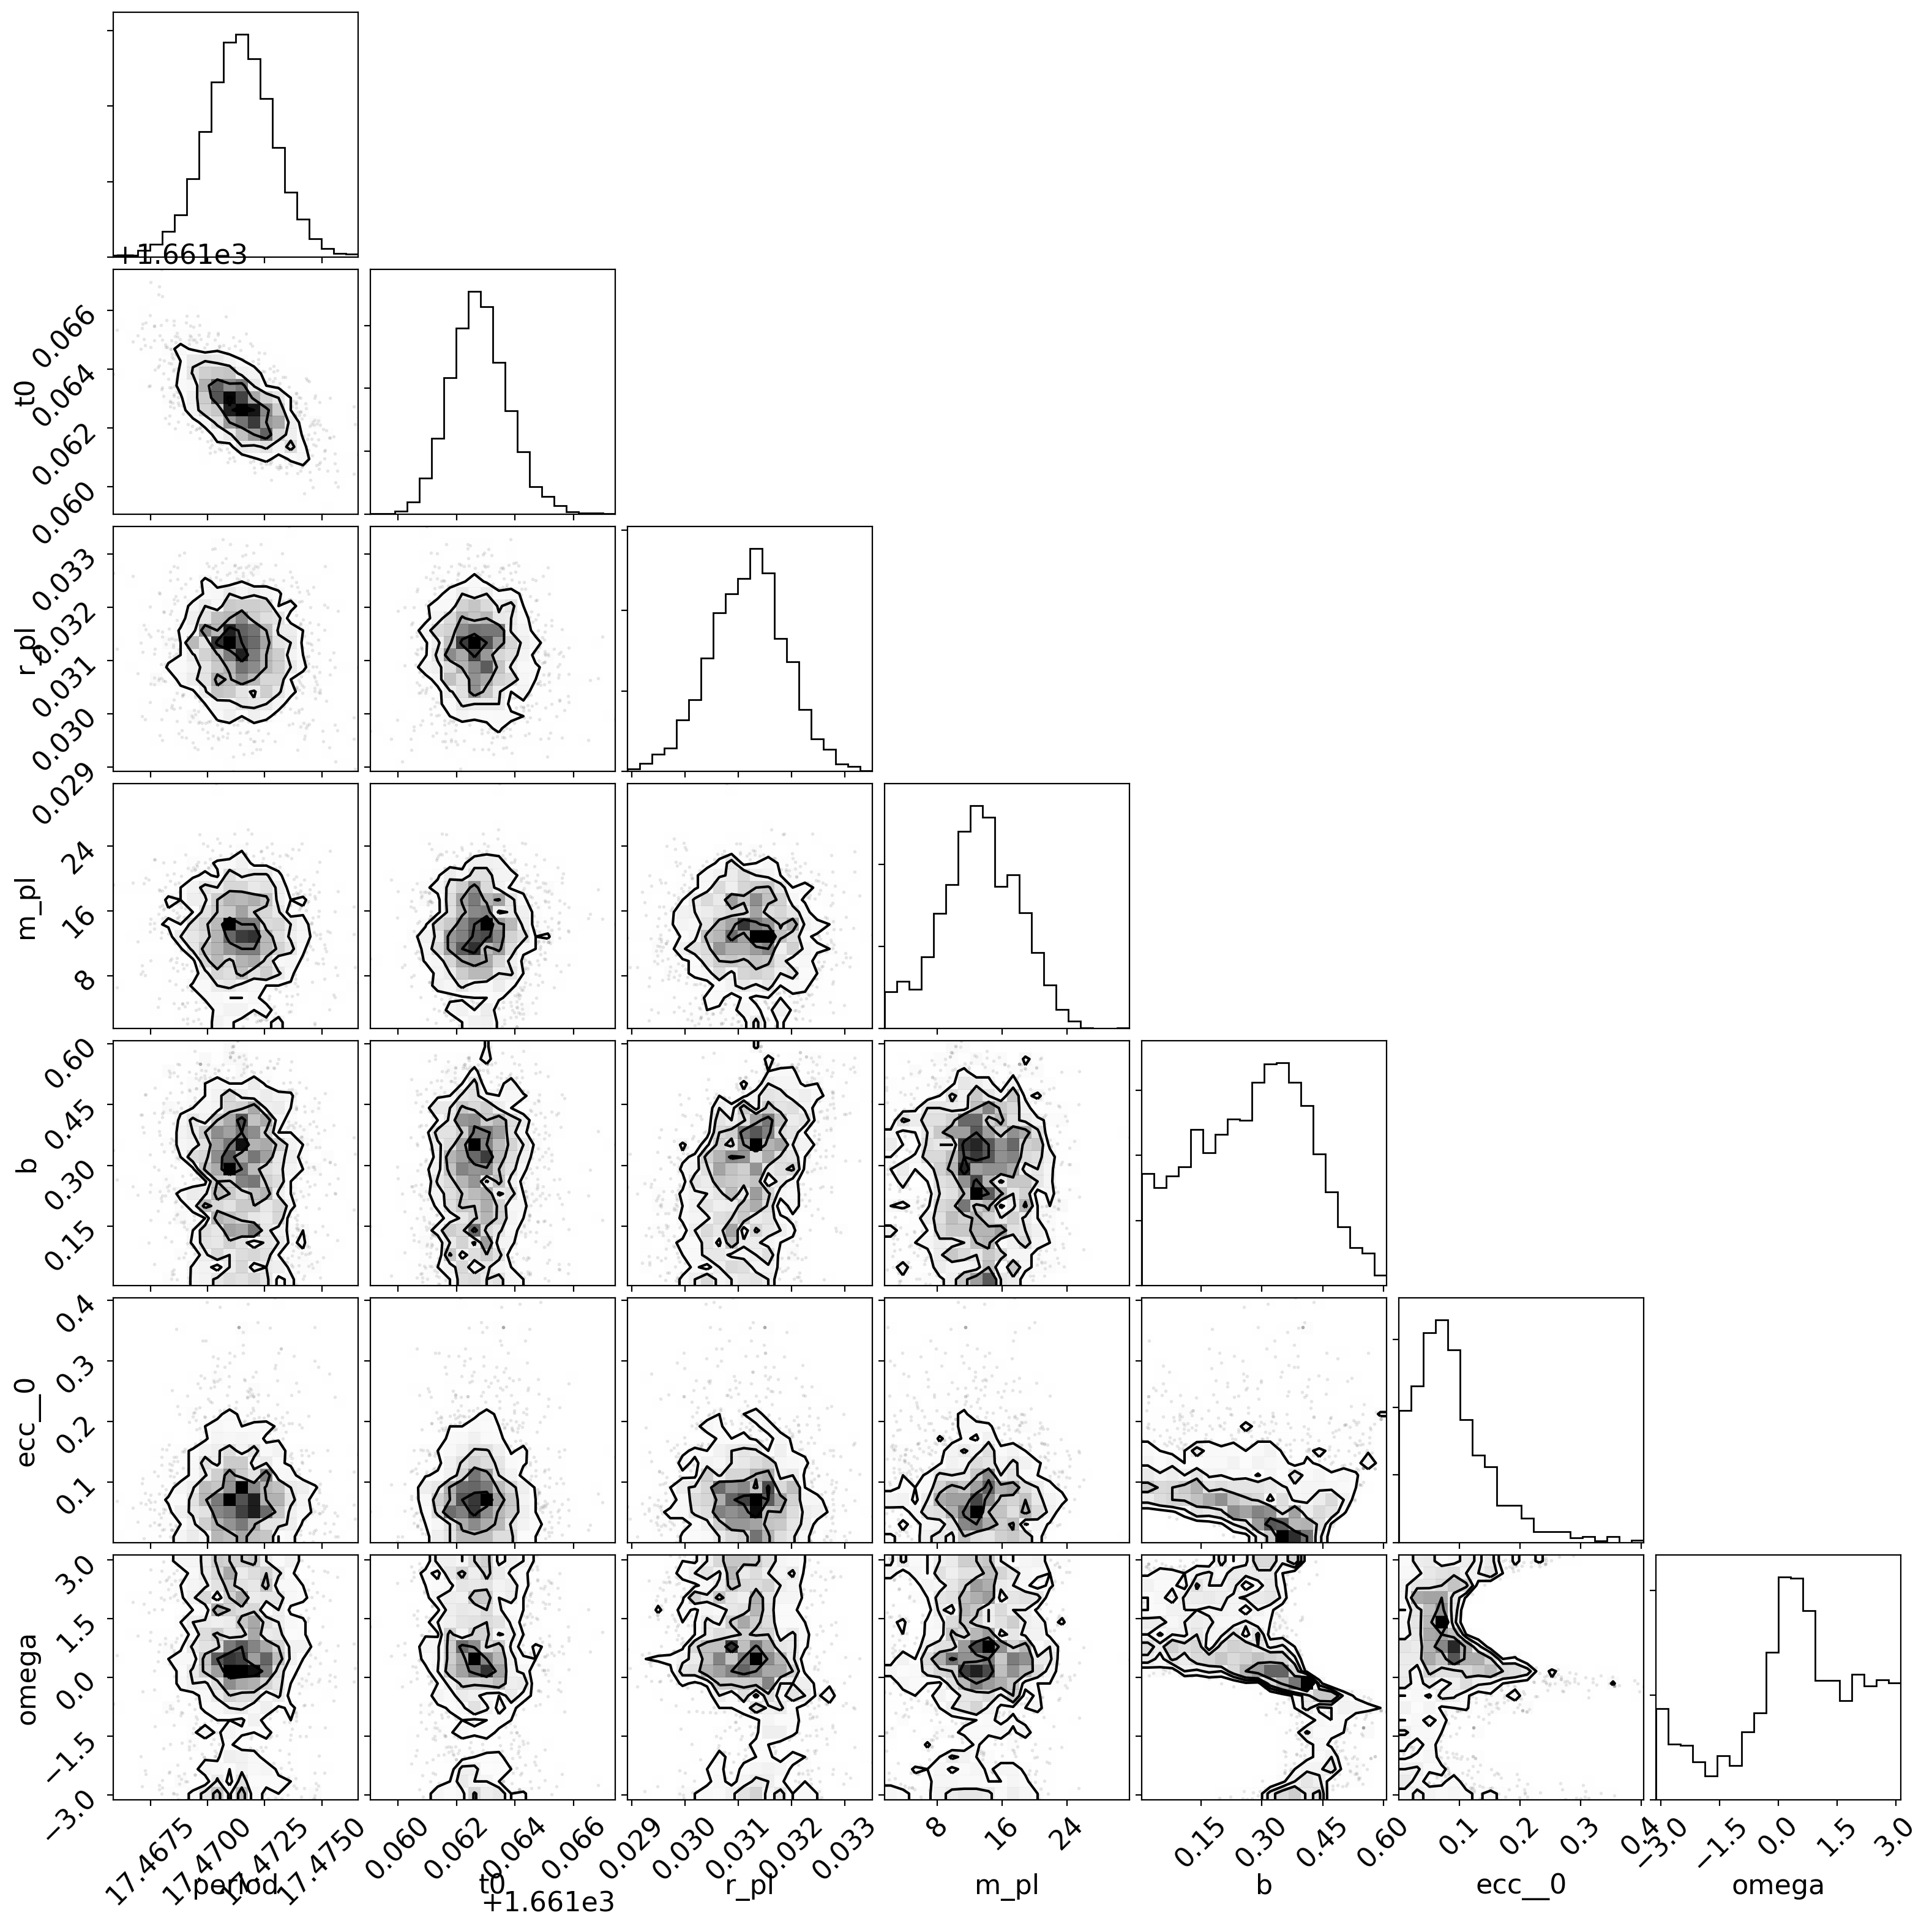

In [27]:
varnames = ["period", "t0", "r_pl", "m_pl", "b", "ecc", "omega"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

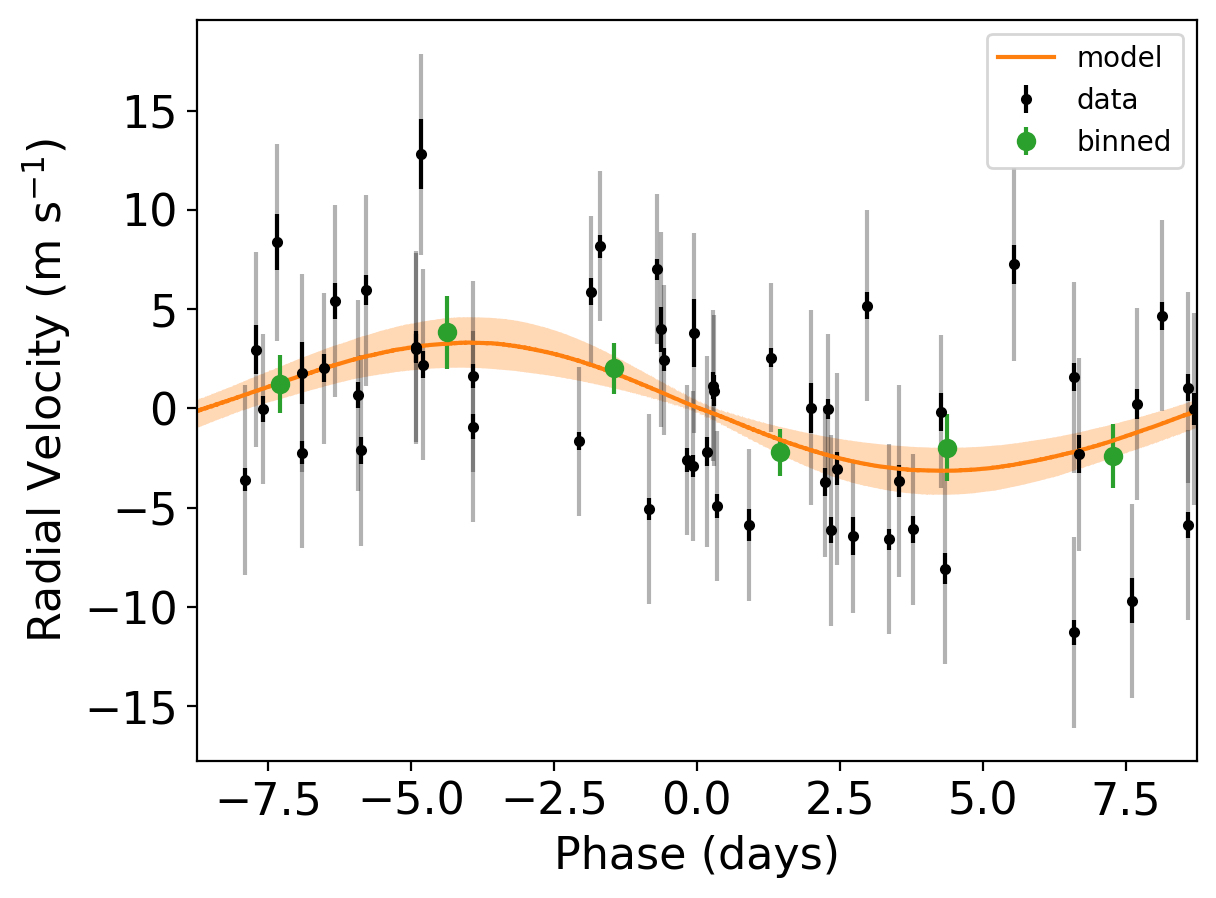

In [32]:
# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])
jit2_pre = np.exp(2*np.median(trace["logs_rv_pre"]))
jit2_pug = np.exp(2*np.median(trace["logs_rv_pug"]))

yerr_corrected = np.copy(yerr_rv**2)
yerr_corrected[~pug] += jit2_pre
yerr_corrected[pug] += jit2_pug
yerr_corrected = np.sqrt(yerr_corrected)


bkg = np.median(trace["bkg"], axis=0)

# Plot the folded data
x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_corrected, fmt=",k", alpha=0.3)
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_rv, fmt=".k", label="data")

bins = np.linspace(-0.5 * p, 0.5*p, 7)
num, _ = np.histogram(x_fold, bins, weights=(y_rv - bkg) / yerr_corrected**2)
denom, _ = np.histogram(x_fold, bins, weights=1 / yerr_corrected**2)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Compute the posterior prediction for the folded RV model for this
# planet
t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
pred = np.percentile(trace["vrad_pred"][:, inds], [16, 50, 84], axis=0)
plt.plot(t_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("Phase (days)")
plt.ylabel("Radial Velocity (m s$^{-1}$)")
plt.tight_layout()
plt.savefig(plot_dir+'rvphased_1pl_wfwhm.pdf');

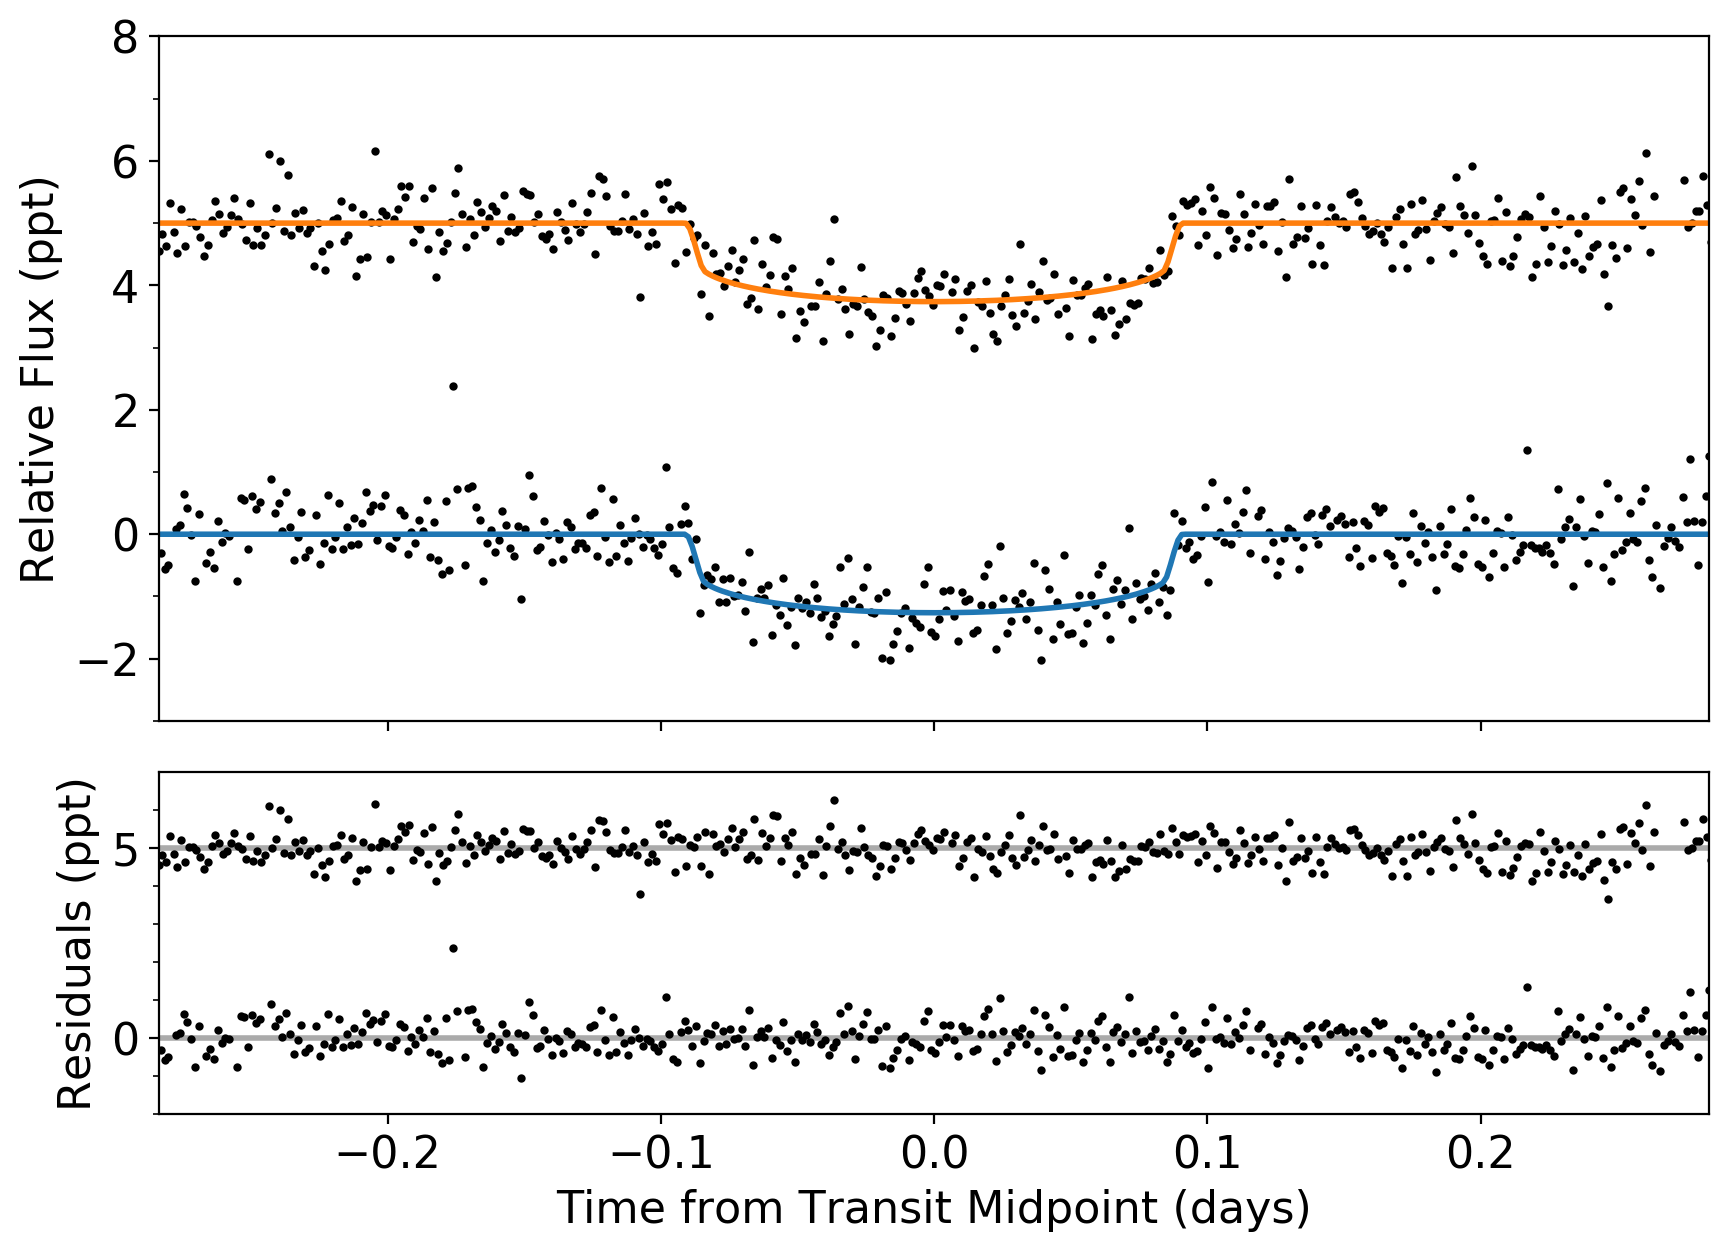

In [29]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True, gridspec_kw={'hspace':0.1, 'height_ratios':[2,1]})
    
with model:
    gp_mod, lc_mod = xo.eval_in_model([
        model.gp_pred + model.mean_flux, model.light_curve - model.mean_flux], map_soln)

transit_midtimes = map_soln['t0'] + map_soln['period'] * np.arange(2)
transit_duration = map_soln['r_star'] * map_soln['period'] / (np.pi * map_soln['a']) # approximate
for i,tt in enumerate(transit_midtimes):
    yoffset = i*5.
    xoffset = tt
    ax1.plot(x - xoffset, y - gp_mod + yoffset, "k.", ms=4)
    ax1.plot(x - xoffset, lc_mod + yoffset, lw=2)
    
    ax2.axhline(yoffset, color="#aaaaaa", lw=2)
    ax2.plot(x - xoffset, y - gp_mod - lc_mod + yoffset, 'k.', ms=4)
    
ax1.set_xlim(np.array([-1.5,1.5]) * transit_duration)
ax2.set_xlabel('Time from Transit Midpoint (days)')
ax1.set_ylabel('Relative Flux (ppt)')
ax2.set_ylabel('Residuals (ppt)')

ax1.set_ylim([-3,8])
ax1.set_yticks(np.arange(-3,8,1), minor=True)
ax2.set_ylim([-2,7])
ax2.set_yticks(np.arange(-2,7,1), minor=True)

fig.savefig(plot_dir+'transits.pdf');

### 2-planet fit with FWHM:

In [30]:
periods = np.array([17.47114, 120.1])
t0s = np.array([1661.0628, 1000.])

n_pl = len(periods)

In [31]:
msini = xo.estimate_minimum_mass(periods, x_rv, y_rv_guess, yerr_rv, t0s=t0s, m_star=mass_radius_mu[0])
msini = msini.to(u.M_earth)
print(msini)

[11.01388962 42.22592222] earthMass


### 1-planet fit with BIS correlation: